<a href="https://colab.research.google.com/github/VelagapudiGokhul/HackVerse/blob/main/Spotify_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional


In [ ]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('words')
nltk.download('maxent_ne_chunker_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.


True

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Analyzing Dataset

In [ ]:
df = pd.read_csv('reviews.csv')

In [ ]:
print(f"Dataset shape : {df.shape}")

Dataset shape : (61594, 5)


In [ ]:
print(f"Feature names : {df.columns.values}")

Feature names : ['Time_submitted' 'Review' 'Rating' 'Total_thumbsup' 'Reply']


In [ ]:
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,09-07-2022 15:00,"Great music service, the audio is high quality...",5,2,NaN
1,09-07-2022 14:21,Please ignore previous negative rating. This a...,5,1,NaN
2,09-07-2022 13:27,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,09-07-2022 13:26,Really buggy and terrible to use as of recently,1,1,NaN
4,09-07-2022 13:20,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [ ]:
df.isnull().sum()

,0
Time_submitted,0
Review,0
Rating,0
Total_thumbsup,0
Reply,61378
length,0


In [ ]:
df['length'] = df['Review'].apply(len)

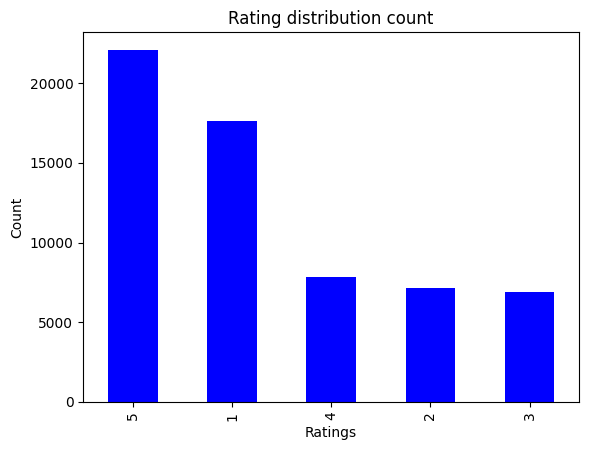

In [ ]:
df['Rating'].value_counts().plot.bar(color = 'blue')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

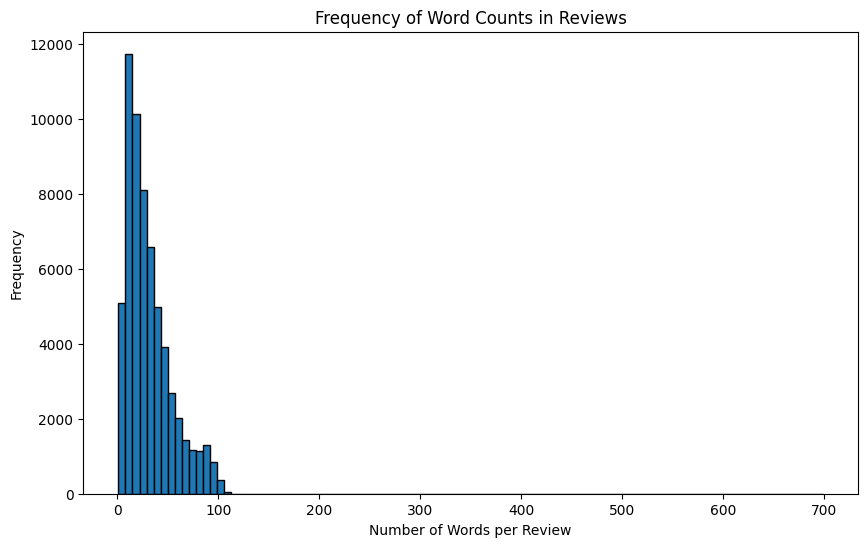

In [ ]:
df['Word_Count'] = df['Review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(df['Word_Count'], bins=100, edgecolor='k')
plt.title('Frequency of Word Counts in Reviews')
plt.xlabel('Number of Words per Review')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(f"Rating value count: \n{df['Rating'].value_counts()}")

Rating value count: 
Rating
5    22095
1    17653
4     7842
2     7118
3     6886
Name: count, dtype: int64


# NLTK


In [ ]:
example = df['Review'][90]
print(example)

I love Spotify, I listen more and more, music an podcasts. We have a premium account, it's worth every penny.


In [ ]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['I', 'love', 'Spotify', ',', 'I', 'listen', 'more', 'and', 'more', ',']

In [ ]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('I', 'PRP'),
 ('love', 'VBP'),
 ('Spotify', 'NNP'),
 (',', ','),
 ('I', 'PRP'),
 ('listen', 'VBP'),
 ('more', 'JJR'),
 ('and', 'CC'),
 ('more', 'RBR'),
 (',', ',')]

In [ ]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  I/PRP
  love/VBP
  (PERSON Spotify/NNP)
  ,/,
  I/PRP
  listen/VBP
  more/JJR
  and/CC
  more/RBR
  ,/,
  music/NN
  an/DT
  podcasts/NNS
  ./.
  We/PRP
  have/VBP
  a/DT
  premium/JJ
  account/NN
  ,/,
  it/PRP
  's/VBZ
  worth/JJ
  every/DT
  penny/NN
  ./.)


#Vader Sentiment Analysis

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.711, 'pos': 0.289, 'compound': 0.7269}

In [ ]:
def analyze_sentiment(text):
    sentiment = sia.polarity_scores(text)
    compound_score = sentiment['compound']
    if compound_score >= 0.05:
        sentiment_label = 'Positive'
    elif compound_score <= -0.05:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'

    return sentiment_label, compound_score

In [ ]:
df['Sentiment'] = df['Review'].apply(analyze_sentiment)

In [ ]:
df[['Sentiment', 'Polarity_Score']] = df['Review'].apply(lambda x: pd.Series(analyze_sentiment(x)))

In [ ]:
def get_vader_scores(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['pos'], sentiment['neu'], sentiment['neg']

In [ ]:
df[['pos', 'neu', 'neg']] = df['Review'].apply(lambda x: pd.Series(get_vader_scores(x)))

vaders = df[['Review', 'pos', 'neu', 'neg']]

In [ ]:
vaders = df[['Review', 'Sentiment', 'Polarity_Score', 'pos', 'neu', 'neg']].copy()
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders.head()

,Id,Review,Sentiment,Polarity_Score,pos,neu,neg
0,0,"Great music service, the audio is high quality...",Positive,0.9211,0.436,0.564,0.000
1,1,Please ignore previous negative rating. This a...,Positive,0.6249,0.404,0.353,0.243
2,2,"This pop-up ""Get the best Spotify experience o...",Positive,0.5859,0.258,0.635,0.107
3,3,Really buggy and terrible to use as of recently,Negative,-0.5209,0.000,0.704,0.296
4,4,Dear Spotify why do I get songs that I didn't ...,Positive,0.7149,0.260,0.740,0.000


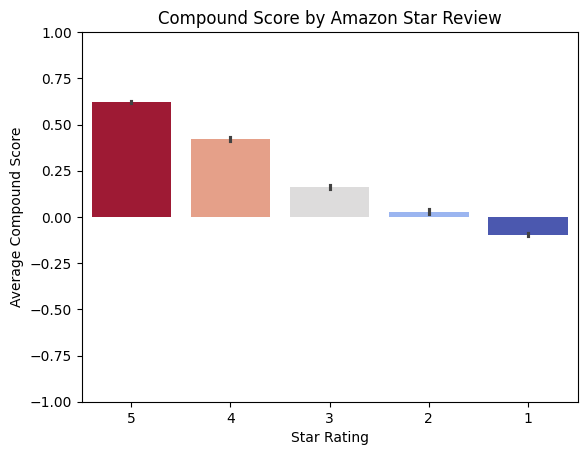

In [ ]:
ax = sns.barplot(
    data=vaders,
    x='Rating',
    y='Polarity_Score',
    order=[5, 4, 3, 2, 1],
    hue='Rating',
    palette='coolwarm',
    legend=False
)

ax.set_title('Compound Score by Amazon Star Review')
ax.set_xlabel('Star Rating')
ax.set_ylabel('Average Compound Score')
plt.ylim(-1, 1)
plt.show()

In [ ]:
df.to_csv("sentiment.csv", index=False)

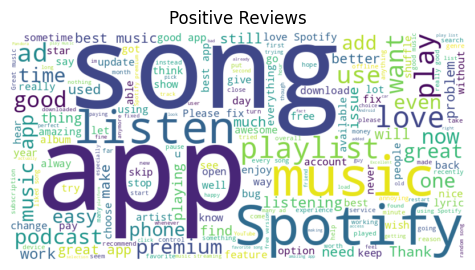

In [ ]:
positive_reviews = df[df['Sentiment'] == 'Positive']['Review']
positive_text = ' '.join(positive_reviews)
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews')
plt.show()

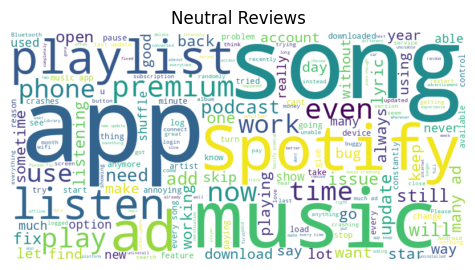

In [ ]:
neutral_reviews = df[df['Sentiment'] == 'Neutral']['Review']
neutral_text = ' '.join(neutral_reviews)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Reviews')
plt.show()

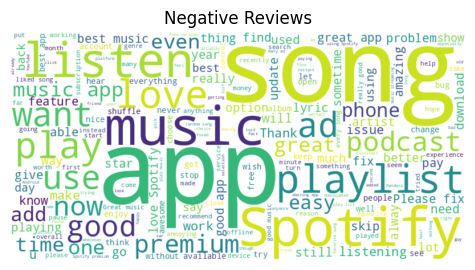

In [ ]:
negative_reviews = df[df['Sentiment'] == 'Negative']['Review']
negative_text = ' '.join(positive_reviews)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews')
plt.show()

# Random Forest

In [ ]:
X = df['Review']
y = df['Sentiment']

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 76.82%


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.76      0.52      0.62      3462
     Neutral       0.82      0.21      0.34       969
    Positive       0.77      0.94      0.85      7888

    accuracy                           0.77     12319
   macro avg       0.78      0.56      0.60     12319
weighted avg       0.77      0.77      0.74     12319



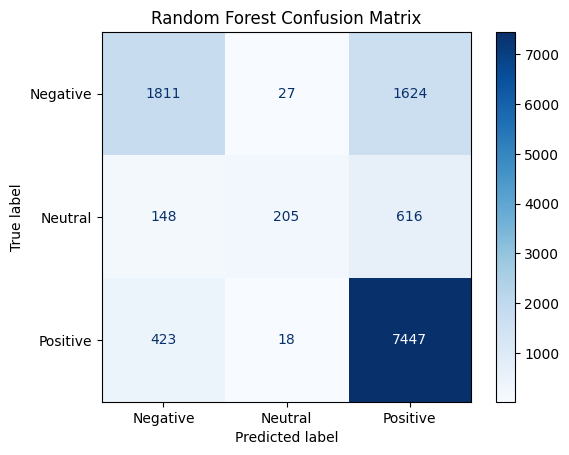

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(y)))
disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()

# LSTM

In [ ]:
texts = df["Review"].astype(str).tolist()
labels = df["Sentiment"].tolist()

In [ ]:
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
y = to_categorical(y)

In [ ]:
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_len)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes: Positive, Negative, Neutral

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X, y, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 244s 156ms/step - accuracy: 0.7264 - loss: 0.6597 - val_accuracy: 0.8471 - val_loss: 0.4128
Epoch 2/5
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 261s 156ms/step - accuracy: 0.8742 - loss: 0.3540 - val_accuracy: 0.8907 - val_loss: 0.3122
Epoch 3/5
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 263s 156ms/step - accuracy: 0.9183 - loss: 0.2521 - val_accuracy: 0.9006 - val_loss: 0.3040
Epoch 4/5
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 260s 155ms/step - accuracy: 0.9341 - loss: 0.2023 - val_accuracy: 0.9026 - val_loss: 0.3071
Epoch 5/5
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 261s 154ms/step - accuracy: 0.9451 - loss: 0.1763 - val_accuracy: 0.9030 - val_loss: 0.3200


In [ ]:
model.save('model.h5')

In [ ]:
from keras.models import load_model

loaded_model = load_model('model.h5')
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,420,037 (5.42 MB)

 Trainable params: 1,420,035 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
example = df['Review'][126]
print("Example review:", example)

Example review: Amazing songs and artists!!! Great app 10/10 review!!


In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Review'])
sequence = tokenizer.texts_to_sequences([example])
padded_sequence = pad_sequences(sequence, maxlen=max_len)

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('model.h5')
predictions = loaded_model.predict(padded_sequence)

predicted_label = predictions.argmax(axis=-1)
print(f"Predicted class index: {predicted_label}")

class_labels = ['Negative', 'Neutral', 'Positive']
predicted_class = class_labels[predicted_label[0]]
print(f"Predicted sentiment: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
Predicted class index: [2]
Predicted sentiment: Positive
